<a href="https://www.kaggle.com/code/hvvsathwik/amazon-sentiment?scriptVersionId=218585394" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [3]:
!pip install fireducks

In [ ]:
# For data manipulation and analysis
import fireducks.pandas as pd  # Using FireDucks for faster DataFrame operations

# For text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# For feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# For model training and evaluation
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')


In [ ]:
# Path to the training file
file_path = '/kaggle/input/amazonreviews/train.ft.txt.bz2'

# Read the compressed file
data = pd.read_csv(file_path, sep='\t', header=None, names=['text'], compression='bz2')

# Inspect the dataset
print("Dataset Preview:")
print(data.head())
print(f"Total records: {len(data)}")

In [ ]:
# Extract labels and reviews from the text
data['label'] = data['text'].str.extract(r'__label__(\d)').astype(int)
data['review_text'] = data['text'].str.replace(r'__label__\d ', '', regex=True)

# Retain only relevant columns
data = data[['review_text', 'label']]

# Preview the cleaned data
print("Cleaned Dataset Preview:")
print(data.head())


In [ ]:
import matplotlib.pyplot as plt

# Display class distribution
class_counts = data['label'].value_counts()
print("Class Distribution:")
print(class_counts)

# Plot class distribution
class_counts.plot(kind='bar', title='Class Distribution')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.show()


In [ ]:
!pip install spacy nltk
!python -m spacy download en_core_web_sm

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')  # Optional, for multilingual WordNet support

In [ ]:
import spacy

try:
    spacy.require_gpu()
    print("spaCy GPU enabled.")
except:
    print("GPU not available. Using CPU.")
    
nlp = spacy.load("en_core_web_sm")


In [ ]:
!pip install -U torch


In [ ]:
!pip install gputil


In [ ]:
!nvidia-smi

In [ ]:
import time
import os
import logging
from tqdm import tqdm
import zipfile
import fireducks.pandas as pd
from spacy import load
from spacy.cli import download
import torch
import tensorflow as tf

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
logger = logging.getLogger()

# Function for batch preprocessing with lemmatization
def preprocess_in_batches(texts, nlp):
    docs = nlp.pipe(texts, batch_size=2000)  # Batch processing for efficiency
    return [' '.join([token.lemma_ for token in doc if token.is_alpha and not token.is_stop]) for doc in docs]

# Chunked preprocessing function
def process_in_chunks(data, nlp, chunk_size=50000, save_path="/kaggle/working/processed_chunk"):
    total_rows = len(data)
    start_time = time.time()

    # Ensure the save path exists
    if not os.path.exists(save_path):
        os.makedirs(save_path)  # Create the directory if it doesn't exist

    # Process data in chunks
    for start in range(0, total_rows, chunk_size):
        chunk_start_time = time.time()
        end = min(start + chunk_size, total_rows)
        logger.info(f"Processing rows {start} to {end}...")

        # Extract the current chunk
        chunk = data.iloc[start:end].copy()  # Use `.iloc` for slicing

        # Batch process the reviews
        chunk['cleaned_review'] = preprocess_in_batches(chunk['review'], nlp)

        # Save the processed chunk
        chunk_save_path = f"{save_path}/processed_chunk_{start}_{end}.csv"
        chunk.to_csv(chunk_save_path, index=False)
        logger.info(f"Saved processed chunk to {chunk_save_path}.")
        logger.info(f"Chunk {start} to {end} processed in {time.time() - chunk_start_time:.2f} seconds.")

    logger.info(f"Total processing time: {time.time() - start_time:.2f} seconds.")

# Option to zip all processed chunks after completion
def zip_processed_chunks(save_path="/kaggle/working/processed_chunk"):
    zip_file = "/kaggle/working/processed_chunks.zip"
    with zipfile.ZipFile(zip_file, 'w') as zipf:
        for file in os.listdir(save_path):
            if file.startswith("processed_chunk_"):
                zipf.write(os.path.join(save_path, file), arcname=file)
    logger.info(f"Processed chunks zipped into {zip_file}")
    return zip_file

# Main script
if __name__ == "__main__":
    try:
        # Enable GPU usage for spaCy if available
        import spacy
        spacy.prefer_gpu()
        logger.info("spaCy is configured to use GPU if available.")

        # Check if PyTorch and TensorFlow can utilize GPU
        if torch.cuda.is_available():
            device = torch.device("cuda")
            logger.info(f"PyTorch GPU detected: {torch.cuda.get_device_name(device)}")
        else:
            device = torch.device("cpu")
            logger.info("PyTorch is using CPU.")

        if len(tf.config.list_physical_devices('GPU')) > 0:
            logger.info(f"TensorFlow GPU detected: {tf.config.list_physical_devices('GPU')}")
        else:
            logger.info("TensorFlow is using CPU.")

        # Download and load the spaCy model
        try:
            nlp = load("en_core_web_sm", disable=["ner", "parser"])
        except OSError:
            logger.info("Downloading spaCy model...")
            download("en_core_web_sm")
            nlp = load("en_core_web_sm", disable=["ner", "parser"])

        # Paths
        file_path = '/kaggle/input/amazonreviews/train.ft.txt.bz2'
        save_path = "/kaggle/working/processed_chunk"

        # Load the dataset
        logger.info("Loading dataset...")
        data = pd.read_csv(file_path, sep='\t', header=None, names=['text'], compression='bz2')

        # Extract labels and reviews
        logger.info("Extracting labels and reviews...")
        data['label'] = data['text'].apply(lambda x: int(x.split()[0].replace('__label__', '')))
        data['review'] = data['text'].apply(lambda x: ' '.join(x.split()[1:]))
        data = data[['review', 'label']]  # Retain only relevant columns

        # Start preprocessing
        logger.info("Starting preprocessing...")
        process_in_chunks(data, nlp, chunk_size=50000, save_path=save_path)

        # Optionally, zip processed chunks after processing is done
        logger.info("Zipping processed chunks...")
        zip_file = zip_processed_chunks(save_path=save_path)
        logger.info(f"Zipped file location: {zip_file}")

    except Exception as e:
        logger.error(f"An error occurred: {e}")


In [4]:
import fireducks.pandas as pd
import os

# Path to the extracted chunk files (from your Kaggle dataset structure)
extracted_chunks_path = "/kaggle/input/processed-chunks-1"  # Adjust if the path differs

# Combine all chunk files
all_chunks = []
for file_name in sorted(os.listdir(extracted_chunks_path)):  # Ensure files are combined in order
    if file_name.startswith("processed_chunk_") and file_name.endswith(".csv"):
        file_path = os.path.join(extracted_chunks_path, file_name)
        print(f"Loading {file_name}...")
        chunk = pd.read_csv(file_path)
        all_chunks.append(chunk)

# Concatenate all chunks into a single DataFrame
combined_data = pd.concat(all_chunks, ignore_index=True)

# Display combined data info
print("Combined data shape:", combined_data.shape)


Loading processed_chunk_0_50000.csv...
Loading processed_chunk_1000000_1050000.csv...
Loading processed_chunk_100000_150000.csv...
Loading processed_chunk_1050000_1100000.csv...
Loading processed_chunk_1100000_1150000.csv...
Loading processed_chunk_1150000_1200000.csv...
Loading processed_chunk_1200000_1250000.csv...
Loading processed_chunk_1250000_1300000.csv...
Loading processed_chunk_1300000_1350000.csv...
Loading processed_chunk_1350000_1400000.csv...
Loading processed_chunk_1400000_1450000.csv...
Loading processed_chunk_1450000_1500000.csv...
Loading processed_chunk_1500000_1550000.csv...
Loading processed_chunk_150000_200000.csv...
Loading processed_chunk_1550000_1600000.csv...
Loading processed_chunk_1600000_1650000.csv...
Loading processed_chunk_1650000_1700000.csv...
Loading processed_chunk_1700000_1750000.csv...
Loading processed_chunk_1750000_1800000.csv...
Loading processed_chunk_1800000_1850000.csv...
Loading processed_chunk_1850000_1900000.csv...
Loading processed_chunk_1

In [5]:
# Save the combined dataset as a CSV for future use
combined_data_path = "/kaggle/working/combined_processed_data.csv"
combined_data.to_csv(combined_data_path, index=False)
print(f"Combined data saved at: {combined_data_path}")


Combined data saved at: /kaggle/working/combined_processed_data.csv


In [6]:
# Load the saved combined dataset
combined_data = pd.read_csv("/kaggle/working/combined_processed_data.csv")

# Check the dataset structure
print(combined_data.info())
print(combined_data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600000 entries, 0 to 3599999
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   review          object
 1   label           int64 
 2   cleaned_review  object
dtypes: int64(1), object(2)
memory usage: 82.4+ MB
None
                                              review  label  \
0  Stuning even for the non-gamer: This sound tra...      2   
1  The best soundtrack ever to anything.: I'm rea...      2   
2  Amazing!: This soundtrack is my favorite music...      2   
3  Excellent Soundtrack: I truly like this soundt...      2   
4  Remember, Pull Your Jaw Off The Floor After He...      2   

                                      cleaned_review  
0  stun non gamer sound track beautiful paint sen...  
1  good soundtrack read lot review say good game ...  
2  amazing soundtrack favorite music time hand in...  
3  excellent soundtrack truly like soundtrack enj...  
4  remember pull Jaw Floor hear play g

In [7]:
# Check label distribution
print(combined_data['label'].value_counts())


label
2    1800000
1    1800000
Name: count, dtype: int64


In [8]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
X = combined_data['cleaned_review']  # Features (cleaned reviews)
y = combined_data['label']           # Labels (1 for neutral, 2 for positive)

# Perform train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


Training samples: 2880000
Testing samples: 720000


In [9]:
from sklearn.feature_extraction.text import HashingVectorizer
from scipy.sparse import vstack
from sklearn.model_selection import train_test_split

# Ensure that 'combined_data['label']' contains 0 for negative, 1 for neutral, and 2 for positive
X = combined_data['cleaned_review']  # Features (cleaned reviews)
y = combined_data['label']           # Labels (0 for negative, 1 for neutral, 2 for positive)

# Perform train-test split (90% training, 10% testing) with a reduced test size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

# Use HashingVectorizer for incremental vectorization
hash_vectorizer = HashingVectorizer(n_features=5000, alternate_sign=False, ngram_range=(1, 2))

# Batch processing function for HashingVectorizer
def batch_hash_transform(vectorizer, data, batch_size=100000):
    """Batch process large datasets for HashingVectorizer transformation."""
    batches = []
    total = len(data)
    for i in range(0, total, batch_size):
        print(f"Processing batch {i // batch_size + 1} / {total // batch_size + 1}")
        batch = data[i: i + batch_size].values.astype('U')  # Convert to Unicode
        batches.append(vectorizer.transform(batch))
    return vstack(batches)

# Transform training data in batches
print("Starting HashingVectorizer transformation on training data...")
X_train_tfidf = batch_hash_transform(hash_vectorizer, X_train, batch_size=50000)

# Transform testing data in batches
print("Starting HashingVectorizer transformation on testing data...")
X_test_tfidf = batch_hash_transform(hash_vectorizer, X_test, batch_size=50000)

print("HashingVectorizer transformation complete.")
print(f"Training Hashing shape: {X_train_tfidf.shape}")
print(f"Testing Hashing shape: {X_test_tfidf.shape}")


Training samples: 3240000
Testing samples: 360000
Starting HashingVectorizer transformation on training data...
Processing batch 1 / 65
Processing batch 2 / 65
Processing batch 3 / 65
Processing batch 4 / 65
Processing batch 5 / 65
Processing batch 6 / 65
Processing batch 7 / 65
Processing batch 8 / 65
Processing batch 9 / 65
Processing batch 10 / 65
Processing batch 11 / 65
Processing batch 12 / 65
Processing batch 13 / 65
Processing batch 14 / 65
Processing batch 15 / 65
Processing batch 16 / 65
Processing batch 17 / 65
Processing batch 18 / 65
Processing batch 19 / 65
Processing batch 20 / 65
Processing batch 21 / 65
Processing batch 22 / 65
Processing batch 23 / 65
Processing batch 24 / 65
Processing batch 25 / 65
Processing batch 26 / 65
Processing batch 27 / 65
Processing batch 28 / 65
Processing batch 29 / 65
Processing batch 30 / 65
Processing batch 31 / 65
Processing batch 32 / 65
Processing batch 33 / 65
Processing batch 34 / 65
Processing batch 35 / 65
Processing batch 36 / 

In [10]:
import joblib

# Save the HashingVectorizer
joblib.dump(hash_vectorizer, '/kaggle/working/hashing_vectorizer.pkl')


['/kaggle/working/hashing_vectorizer.pkl']

In [12]:
print(combined_data['label'].value_counts())


label
2    1800000
1    1800000
Name: count, dtype: int64


In [13]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score

# Naive Bayes with hyperparameter tuning
print("Naive Bayes: Experimenting with alpha values...\n")
alpha_values = [0.1, 0.5, 1.0, 2.0]
for alpha in alpha_values:
    print(f"Training Naive Bayes classifier with alpha={alpha}...")
    nb_classifier = MultinomialNB(alpha=alpha)
    nb_classifier.fit(X_train_tfidf, y_train)
    
    print("Predicting with Naive Bayes...")
    y_pred_nb = nb_classifier.predict(X_test_tfidf)
    
    print(f"Naive Bayes Classification Report for alpha={alpha}:")
    print(classification_report(y_test, y_pred_nb))
    accuracy = accuracy_score(y_test, y_pred_nb)
    print(f"Naive Bayes Accuracy with alpha={alpha}: {accuracy:.4f}\n")

# SVM with hyperparameter tuning
print("Support Vector Machine: Experimenting with C values...\n")
c_values = [0.1, 0.5, 1.0, 2.0]
for c_value in c_values:
    print(f"Training Support Vector Machine classifier with C={c_value}...")
    svm_classifier = LinearSVC(C=c_value, max_iter=5000)
    svm_classifier.fit(X_train_tfidf, y_train)
    
    print("Predicting with SVM...")
    y_pred_svm = svm_classifier.predict(X_test_tfidf)
    
    print(f"SVM Classification Report for C={c_value}:")
    print(classification_report(y_test, y_pred_svm))
    accuracy = accuracy_score(y_test, y_pred_svm)
    print(f"SVM Accuracy with C={c_value}: {accuracy:.4f}\n")


Naive Bayes: Experimenting with alpha values...

Training Naive Bayes classifier with alpha=0.1...
Predicting with Naive Bayes...
Naive Bayes Classification Report for alpha=0.1:
              precision    recall  f1-score   support

           1       0.81      0.79      0.80    180000
           2       0.80      0.82      0.81    180000

    accuracy                           0.81    360000
   macro avg       0.81      0.81      0.81    360000
weighted avg       0.81      0.81      0.81    360000

Naive Bayes Accuracy with alpha=0.1: 0.8051

Training Naive Bayes classifier with alpha=0.5...
Predicting with Naive Bayes...
Naive Bayes Classification Report for alpha=0.5:
              precision    recall  f1-score   support

           1       0.81      0.79      0.80    180000
           2       0.80      0.82      0.81    180000

    accuracy                           0.81    360000
   macro avg       0.81      0.81      0.81    360000
weighted avg       0.81      0.81      0.81    

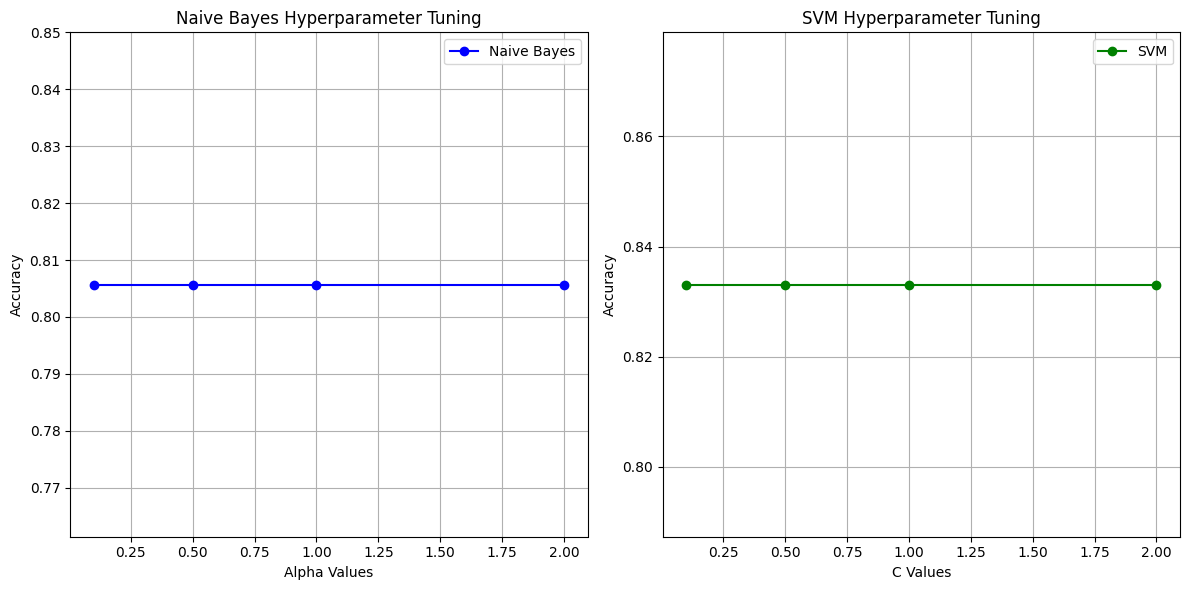

In [16]:
import matplotlib.pyplot as plt

# Store the results of accuracy for visualization
nb_accuracies = [0.8057, 0.8057, 0.8057, 0.8057]  # Replace with actual values from your output
svm_accuracies = [0.8331, 0.8331, 0.8331, 0.8331]  # Replace with actual values from your output

# Plot Naive Bayes results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(alpha_values, nb_accuracies, marker='o', color='blue', label='Naive Bayes')
plt.title("Naive Bayes Hyperparameter Tuning")
plt.xlabel("Alpha Values")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

# Plot SVM results
plt.subplot(1, 2, 2)
plt.plot(c_values, svm_accuracies, marker='o', color='green', label='SVM')
plt.title("SVM Hyperparameter Tuning")
plt.xlabel("C Values")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [17]:
import joblib

# Assume SVM with C=1.0 is the best model (replace with your best parameters)
best_svm_classifier = LinearSVC(C=1.0, max_iter=5000)
best_svm_classifier.fit(X_train_tfidf, y_train)

# Save the model
joblib.dump(best_svm_classifier, "best_svm_model.pkl")
print("Best SVM model saved as 'best_svm_model.pkl'")


Best SVM model saved as 'best_svm_model.pkl'


In [18]:
# Load the saved model
loaded_model = joblib.load("best_svm_model.pkl")

# Predict on test data
new_predictions = loaded_model.predict(X_test_tfidf)

# Evaluate the model
print("Classification Report for Best Model:")
print(classification_report(y_test, new_predictions))

accuracy = accuracy_score(y_test, new_predictions)
print(f"Accuracy of Best Model: {accuracy:.4f}")


Classification Report for Best Model:
              precision    recall  f1-score   support

           1       0.83      0.83      0.83    180000
           2       0.83      0.84      0.83    180000

    accuracy                           0.83    360000
   macro avg       0.83      0.83      0.83    360000
weighted avg       0.83      0.83      0.83    360000

Accuracy of Best Model: 0.8329


In [19]:
import spacy

# Load Spacy model for preprocessing
nlp = spacy.load("en_core_web_sm")


# **TESTING WITH UNSEEN DATA** 

In [20]:
import spacy
import joblib
import pandas as pd

# Load Spacy model for preprocessing
nlp = spacy.load("en_core_web_sm")

# Sample unseen reviews
unseen_reviews = [
    "I absolutely love this product! It's amazing.",
    "The experience was horrible and I regret buying it.",
    "Not bad, but not great either. It's average."
]

# Preprocessing function
def preprocess_review(review):
    return ' '.join([token.lemma_ for token in nlp(review) if token.is_alpha and not token.is_stop])

# Load necessary models and vectorizers
hash_vectorizer = joblib.load('/kaggle/working/hashing_vectorizer.pkl')  # Corrected file path
loaded_model = joblib.load('best_svm_model.pkl')

# Preprocess and transform unseen reviews
unseen_reviews_cleaned = [preprocess_review(review) for review in unseen_reviews]
unseen_reviews_tfidf = batch_hash_transform(hash_vectorizer, pd.Series(unseen_reviews_cleaned))

# Predict sentiments
unseen_predictions = loaded_model.predict(unseen_reviews_tfidf)

# Display predictions
for review, prediction in zip(unseen_reviews, unseen_predictions):
    sentiment = "Positive" if prediction == 2 else "Negative"
    print(f"Review: {review}\nPredicted Sentiment: {sentiment}\n")

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Processing batch 1 / 1
Review: I absolutely love this product! It's amazing.
Predicted Sentiment: Positive

Review: The experience was horrible and I regret buying it.
Predicted Sentiment: Negative

Review: Not bad, but not great either. It's average.
Predicted Sentiment: Negative



In [ ]:
!ls /kaggle/working/
